# US Corn Belt Crop Classifier

The purpose of this project is to develop a crop type classification system for the Corn Belt region of the US. As a pilot version of the project, we evaluate classification methods for the state of Illinois.

## 1. Import required packages

In [2]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Geospatial libraries
import geopandas as gpd
import rasterio
from rasterio.plot import show, show_hist
from rasterio.mask import mask
from osgeo import gdal
from fiona.crs import from_epsg
from shapely.geometry import box

# ML libraries
from sklearn.decomposition import PCA

# System libraries
import os
import time
from glob import glob

## 2. Get some HLS data

The Harmonized Landsat and Sentinel-2 (HLS) dataset processes Landsat OLI and Sentinel-2 images into a common grid and wavelengths such that images from the two sensors can essentially be treated as images from a single sensor. Images are 30 m/px and re-sampled to Landsat OLI wavelengths.

In [6]:
# Define the root directory for the dataset
fp_illinois = '/gpfs/data1/cmongp1/GEOGLAM/Input/field_data/hls/tif'

### Load a relatively cloud-free Landsat image in growing season

The Landsat-8 bands we want to use are:
* blue
* green
* red
* swir1 (1600 nm)
* swir2 (2100 nm ish)

Plus band ratios:
* NDVI
* GCVI

In [7]:
# Define the path template for the image
l30_path = '%s/16SCJ/L30/2018/HLS.L30.T16SCJ.2018213.v1.4_%s.tif'

# Create an np.array to hold the 7 band image (all tiles are 3660 x 3660)
l30_img = np.ndarray([3660, 3660, 7])

# Load each band into the array
for i, band in enumerate(['blue', 'green', 'red', 'swir1', 'swir2', 'ndvi', 'gcvi']):
    l30_fp = os.path.join(fp_illinois, l30_path % (band, band))
    l30_raster = rasterio.open(l30_fp)
    l30_img[:,:,i] = l30_raster.read(1)
    
print l30_raster.meta

{'count': 1, 'crs': CRS.from_epsg(32616), 'dtype': 'float32', 'driver': u'GTiff', 'transform': Affine(30.0, 0.0, 300000.0,
       0.0, -30.0, 4400040.0), 'height': 3660, 'width': 3660, 'nodata': nan}


In [8]:
# Calculate fraction of no-data pixels
nodata = np.where(np.isnan(l30_img))
print("Fraction of pixels that are NaN: %f" % ((len(nodata[0])/7.)/(l30_raster.width*l30_raster.height)))
# Set NaN pixels to 0
l30_img[nodata] = 0

Fraction of pixels that are NaN: 0.249295


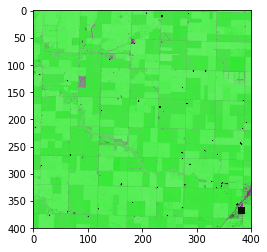

In [9]:
# Select NDVI and SWIR1 bands
img = l30_img[:400,:400]
l30_combined = np.zeros([img.shape[0], img.shape[0], 3])
l30_combined[:,:,0] = np.interp(img[:,:,3], (img[:,:,3].min(), img[:,:,3].max()), (0,1))  # red
l30_combined[:,:,1] = np.interp(img[:,:,5], (img[:,:,5].min(), img[:,:,5].max()), (0,1))  # green
l30_combined[:,:,2] = l30_combined[:,:,0]  # blue + red = purple

# Plot image
plt.imshow(l30_combined)

### Load a relatively cloud-free Sentinel-2 image in growing season

The Sentinel-2 bands that align with the Landsat-8 bands are:
* blue
* green
* red
* swir1 (1600 nm)
* swir2 (2100 nm ish)

Plus band ratios:
* NDVI
* GCVI


In [10]:
# Define the path template for the image
s30_path = '%s/16SCJ/S30/2018/HLS.S30.T16SCJ.2018186.v1.4_%s.tif'

# Create an np.array to hold the 7 band image (all tiles are 3660 x 3660)
s30_img = np.ndarray([3660, 3660, 7])

# Load each band into the array
for i, band in enumerate(['blue', 'green', 'red', 'swir1', 'swir2', 'ndvi', 'gcvi']):
    s30_fp = os.path.join(fp_illinois, s30_path % (band, band))
    s30_raster = rasterio.open(s30_fp)
    s30_img[:,:,i] = s30_raster.read(1)

In [11]:
# Calculate fraction of no-data pixels
nodata = np.where(np.isnan(s30_img))
print("Fraction of pixels that are NaN: %f" % ((len(nodata[0])/7.)/(s30_raster.width*s30_raster.height)))
# Set NaN pixels to 0
s30_img[nodata] = 0

Fraction of pixels that are NaN: 0.091926


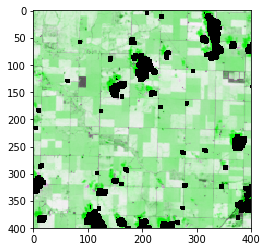

In [12]:
# Select NDVI and SWIR1 bands
img = s30_img[:400,:400]
s30_combined = np.zeros([img.shape[0], img.shape[0], 3])
s30_combined[:,:,0] = np.interp(img[:,:,3], (img[:,:,3].min(), img[:,:,3].max()), (0,1))  # red
s30_combined[:,:,1] = np.interp(img[:,:,5], (img[:,:,5].min(), img[:,:,5].max()), (0,1))  # green
s30_combined[:,:,2] = s30_combined[:,:,0]  # blue + red = purple

# Plot image
plt.imshow(s30_combined)

## 2. Investigate separability

Before designing our ML methods and experiments, we first want to investigate the separability of the crop type classes through visualization. To do this, we need to get the crop type labels associated with the image we are working with.

### Get crop type labels

The Cropland Data Layer (CDL) provides crop type/land cover classes at 30 m/px resolution for the US each year. It is created by the USDA NASS and is released to the public a few months after the end of the growing season (i.e., the following year). The CDL provides 3 bands: 

* Band 1: 254 land cover classes including >100 crop types
* Band 2: binary land cover class of cultivated/non-cultivated
* Band 3: confidence in the predicted class (0-100, 100 being most confident) - can't figure out how to get this from CropScape

In [13]:
# Load CDL layer for 2018 in Illinois
fp = '/gpfs/data1/cmongp1/hkerner/us-corn/data/CDL_2018_illinois.tif'
cdl_2018 = rasterio.open(fp)
crop_types = cdl_2018.read(1)
print cdl_2018.meta

{'count': 1, 'crs': CRS.from_epsg(32616), 'dtype': 'uint8', 'driver': u'GTiff', 'transform': Affine(30.0, 0.0, 115575.0,
       0.0, -30.0, 4712655.0), 'height': 20630, 'width': 11381, 'nodata': None}


This CDL GeoTIFF is for the entire state of Illinois. We want to clip it to the area we are looking at in our example L30 and S30 images (MGRS tile 16SCJ). 

In [15]:
# Insert the bounds of the L30 image into a GeoDataFrame
b = list(l30_raster.bounds)
bbox = box(b[0], b[1], b[2], b[3]) # there must be a better way to do this
# Note: not re-projecting into the same CRS because they are already the same (32616)

crop_types_subset = mask(dataset=cdl_2018, shapes=[bbox], crop=True)
cdl_labels = crop_types_subset[0][0]
cdl_labels.shape # this is one pixel larger in each dimension..???

(3661, 3661)

For now, we only want to look at corn, soybeans, and everything else grouped as a single category.

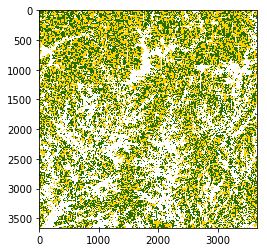

In [16]:
# Display the CDL labels for corn and soybeans only
# Create a 3-channel array to hold the label image
cdl_img = np.ndarray([cdl_labels.shape[0], cdl_labels.shape[1], 4])
# Get the pixels where corn and soybeans are labeled
corn_inds = np.where(cdl_labels==1)
soybean_inds = np.where(cdl_labels==5)
cdl_img[corn_inds[0], corn_inds[1]] = [1, 0.82, 0, 1.0]
cdl_img[soybean_inds[0], soybean_inds[1]] = [0.149, 0.439, 0, 1.0]
plt.imshow(cdl_img)

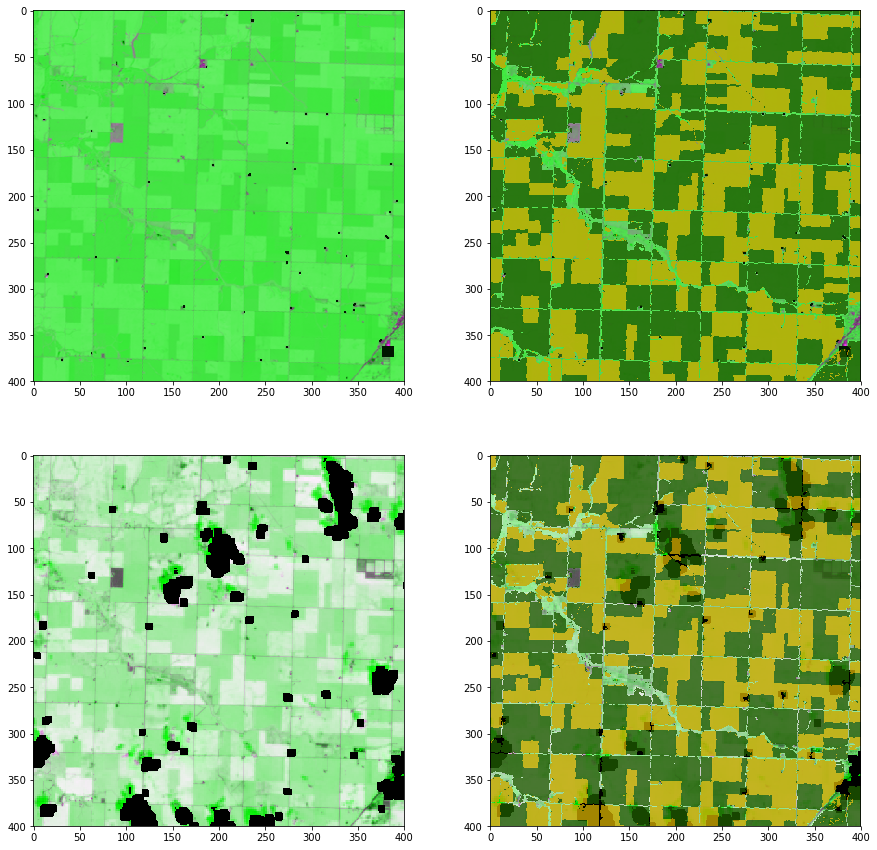

In [12]:
# Display the CDL labels on top of the Landsat and Sentinel-2 images
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=[15,15])
# Display the Landsat image
axes[0,0].imshow(l30_combined)
axes[0,1].imshow(l30_combined)
axes[0,1].imshow(cdl_img[:400, :400]*0.8)
# Display the Sentinel-2 image
axes[1,0].imshow(s30_combined)
axes[1,1].imshow(s30_combined)
axes[1,1].imshow(cdl_img[:400, :400]*0.8)

### NDVI vs. SWIR1

We've seen in prior work by GLAD (e.g., King et al., 2017) that the spectra of corn and soybeans in the midwest can be clearly separated using the SWIR1 (1600 nm) reflectance and "seasonal slope of NDVI". It is not clear how exactly seasonal slope of NDVI is calculated, and in any case this would require the time-series data which is not yet ready (still downloading, evaluating no-data filtering, etc.).

As a start, we can plot NDVI vs. SWIR1 for our example images.

Text(0.5,1,'Landsat-8 NDVI vs. SWIR1, central Illinois (16SCJ), 8/1/2018')

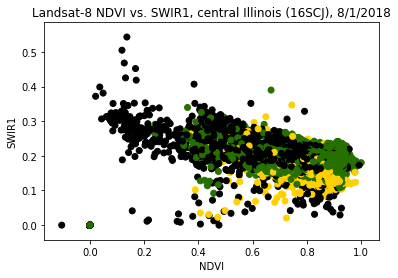

In [13]:
# Plot NDVI vs. SWIR - Landsat
plt.scatter(l30_img[:400, :400, 5].flatten(), l30_img[:400, :400, 3].flatten(), c=np.reshape(cdl_img[:400,:400,:3].flatten(), [400*400,3]))
plt.xlabel('NDVI')
plt.ylabel('SWIR1')
plt.title('Landsat-8 NDVI vs. SWIR1, central Illinois (16SCJ), 8/1/2018')

Text(0.5,1,'Sentinel-2 NDVI vs. SWIR1, central Illinois (16SCJ), 7/5/2018')

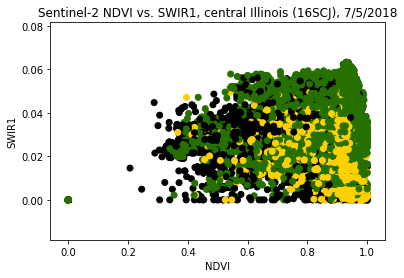

In [14]:
# Plot NDVI vs. SWIR - Sentinel-2
plt.scatter(s30_img[:400, :400, 5].flatten(), s30_img[:400, :400, 3].flatten(), c=np.reshape(cdl_img[:400,:400,:3].flatten(), [400*400,3]))
plt.xlabel('NDVI')
plt.ylabel('SWIR1')
plt.title('Sentinel-2 NDVI vs. SWIR1, central Illinois (16SCJ), 7/5/2018')

In the plots above, yellow is corn, green is soybeans, and black is everything else. These classes are not linearly separable using NDVI and SWIR1 as the only features. We will need to see if incorporating the time-series for NDVI via the seasonal slope of NDVI will make these classes more linearly separable.

Important note: we are only looking at one ~12x12 km subset of the data here. It's possible that this could look different over a larger or randomly-sampled area.

### All band combinations

To see which bands might help separate the crop type classes, let's plot every combination of band reflectances for all the pixels in our example dataset.

In [19]:
bands = ['blue', 'green', 'red', 'swir1', 'swir2', 'ndvi', 'gcvi']

Text(0.5,0.98,'Sentinel-2 Band Combinations')

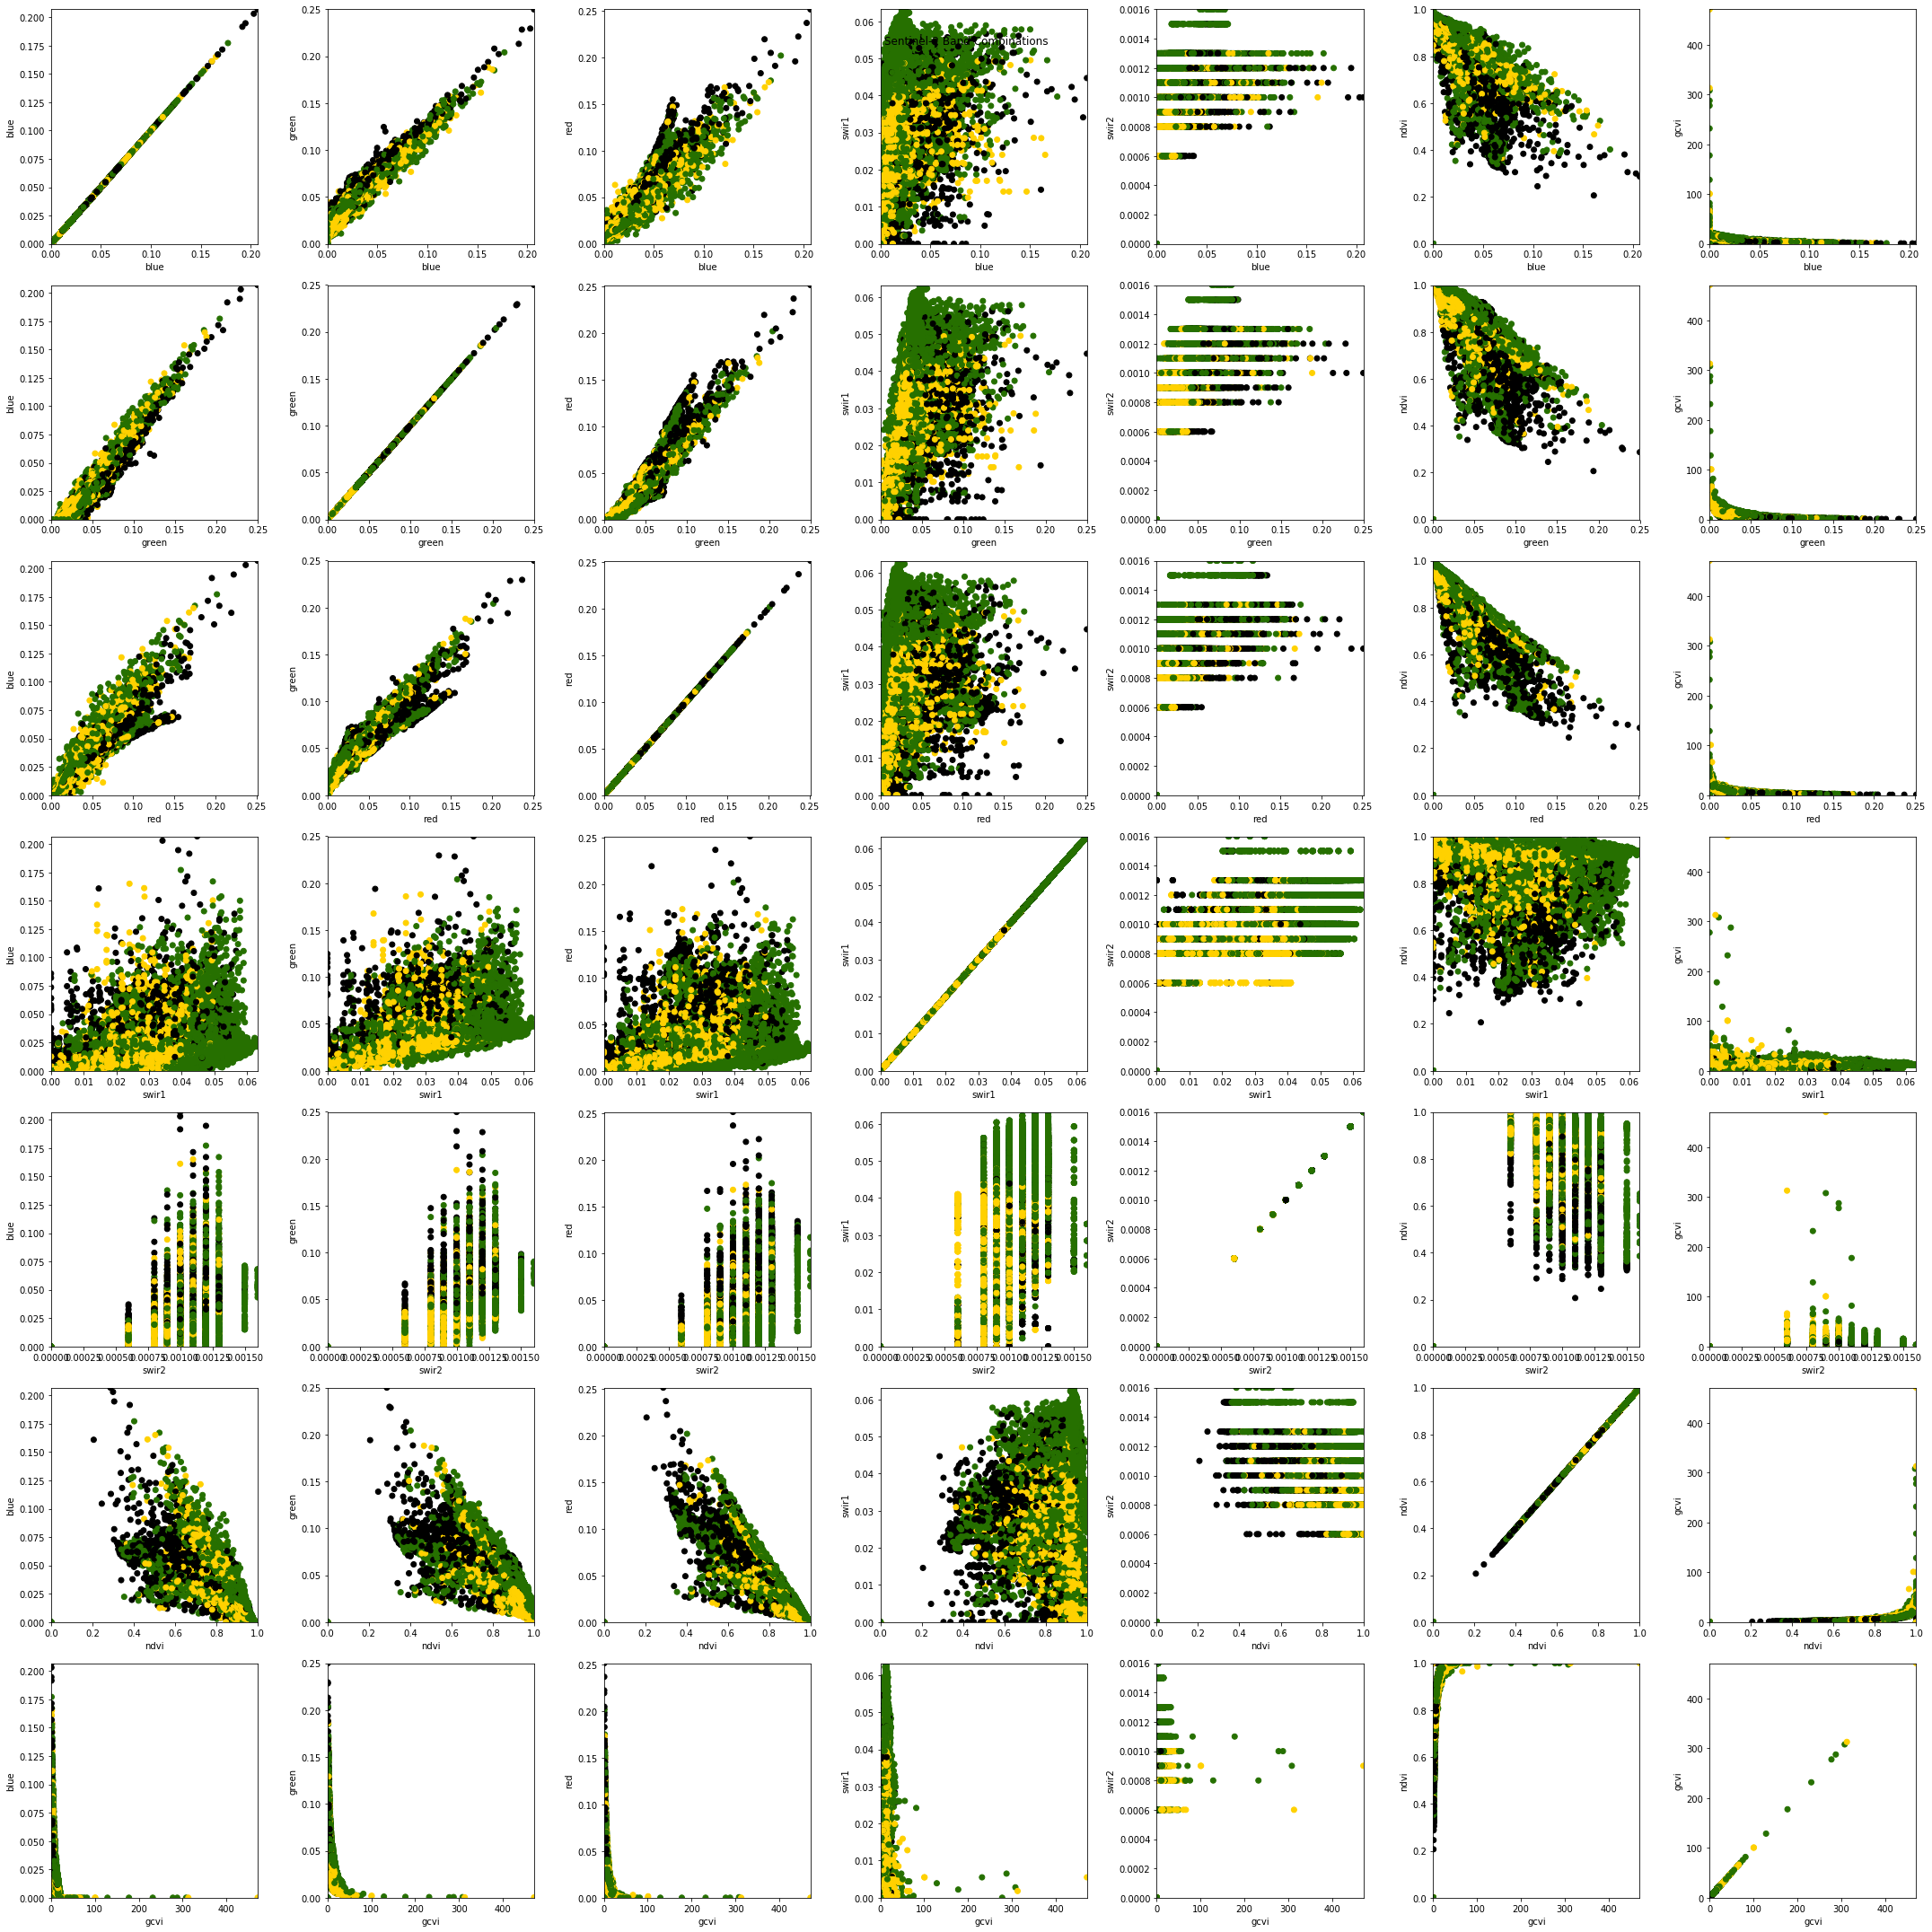

In [15]:
fig, ax = plt.subplots(nrows=7, ncols=7, figsize=[30,30])
for i in range(7):
    for j in range(7):
        ax[i,j].scatter(s30_img[:400, :400, i].flatten(), s30_img[:400, :400, j].flatten(), c=np.reshape(cdl_img[:400,:400,:3].flatten(), [400*400,3]))
        ax[i,j].set_xlabel(bands[i])
        ax[i,j].set_ylabel(bands[j])
        ax[i,j].set_xlim(s30_img[:400, :400, i].min(), s30_img[:400, :400, i].max())
        ax[i,j].set_ylim(s30_img[:400, :400, j].min(), s30_img[:400, :400, j].max())

fig.tight_layout()
fig.suptitle("Sentinel-2 Band Combinations")

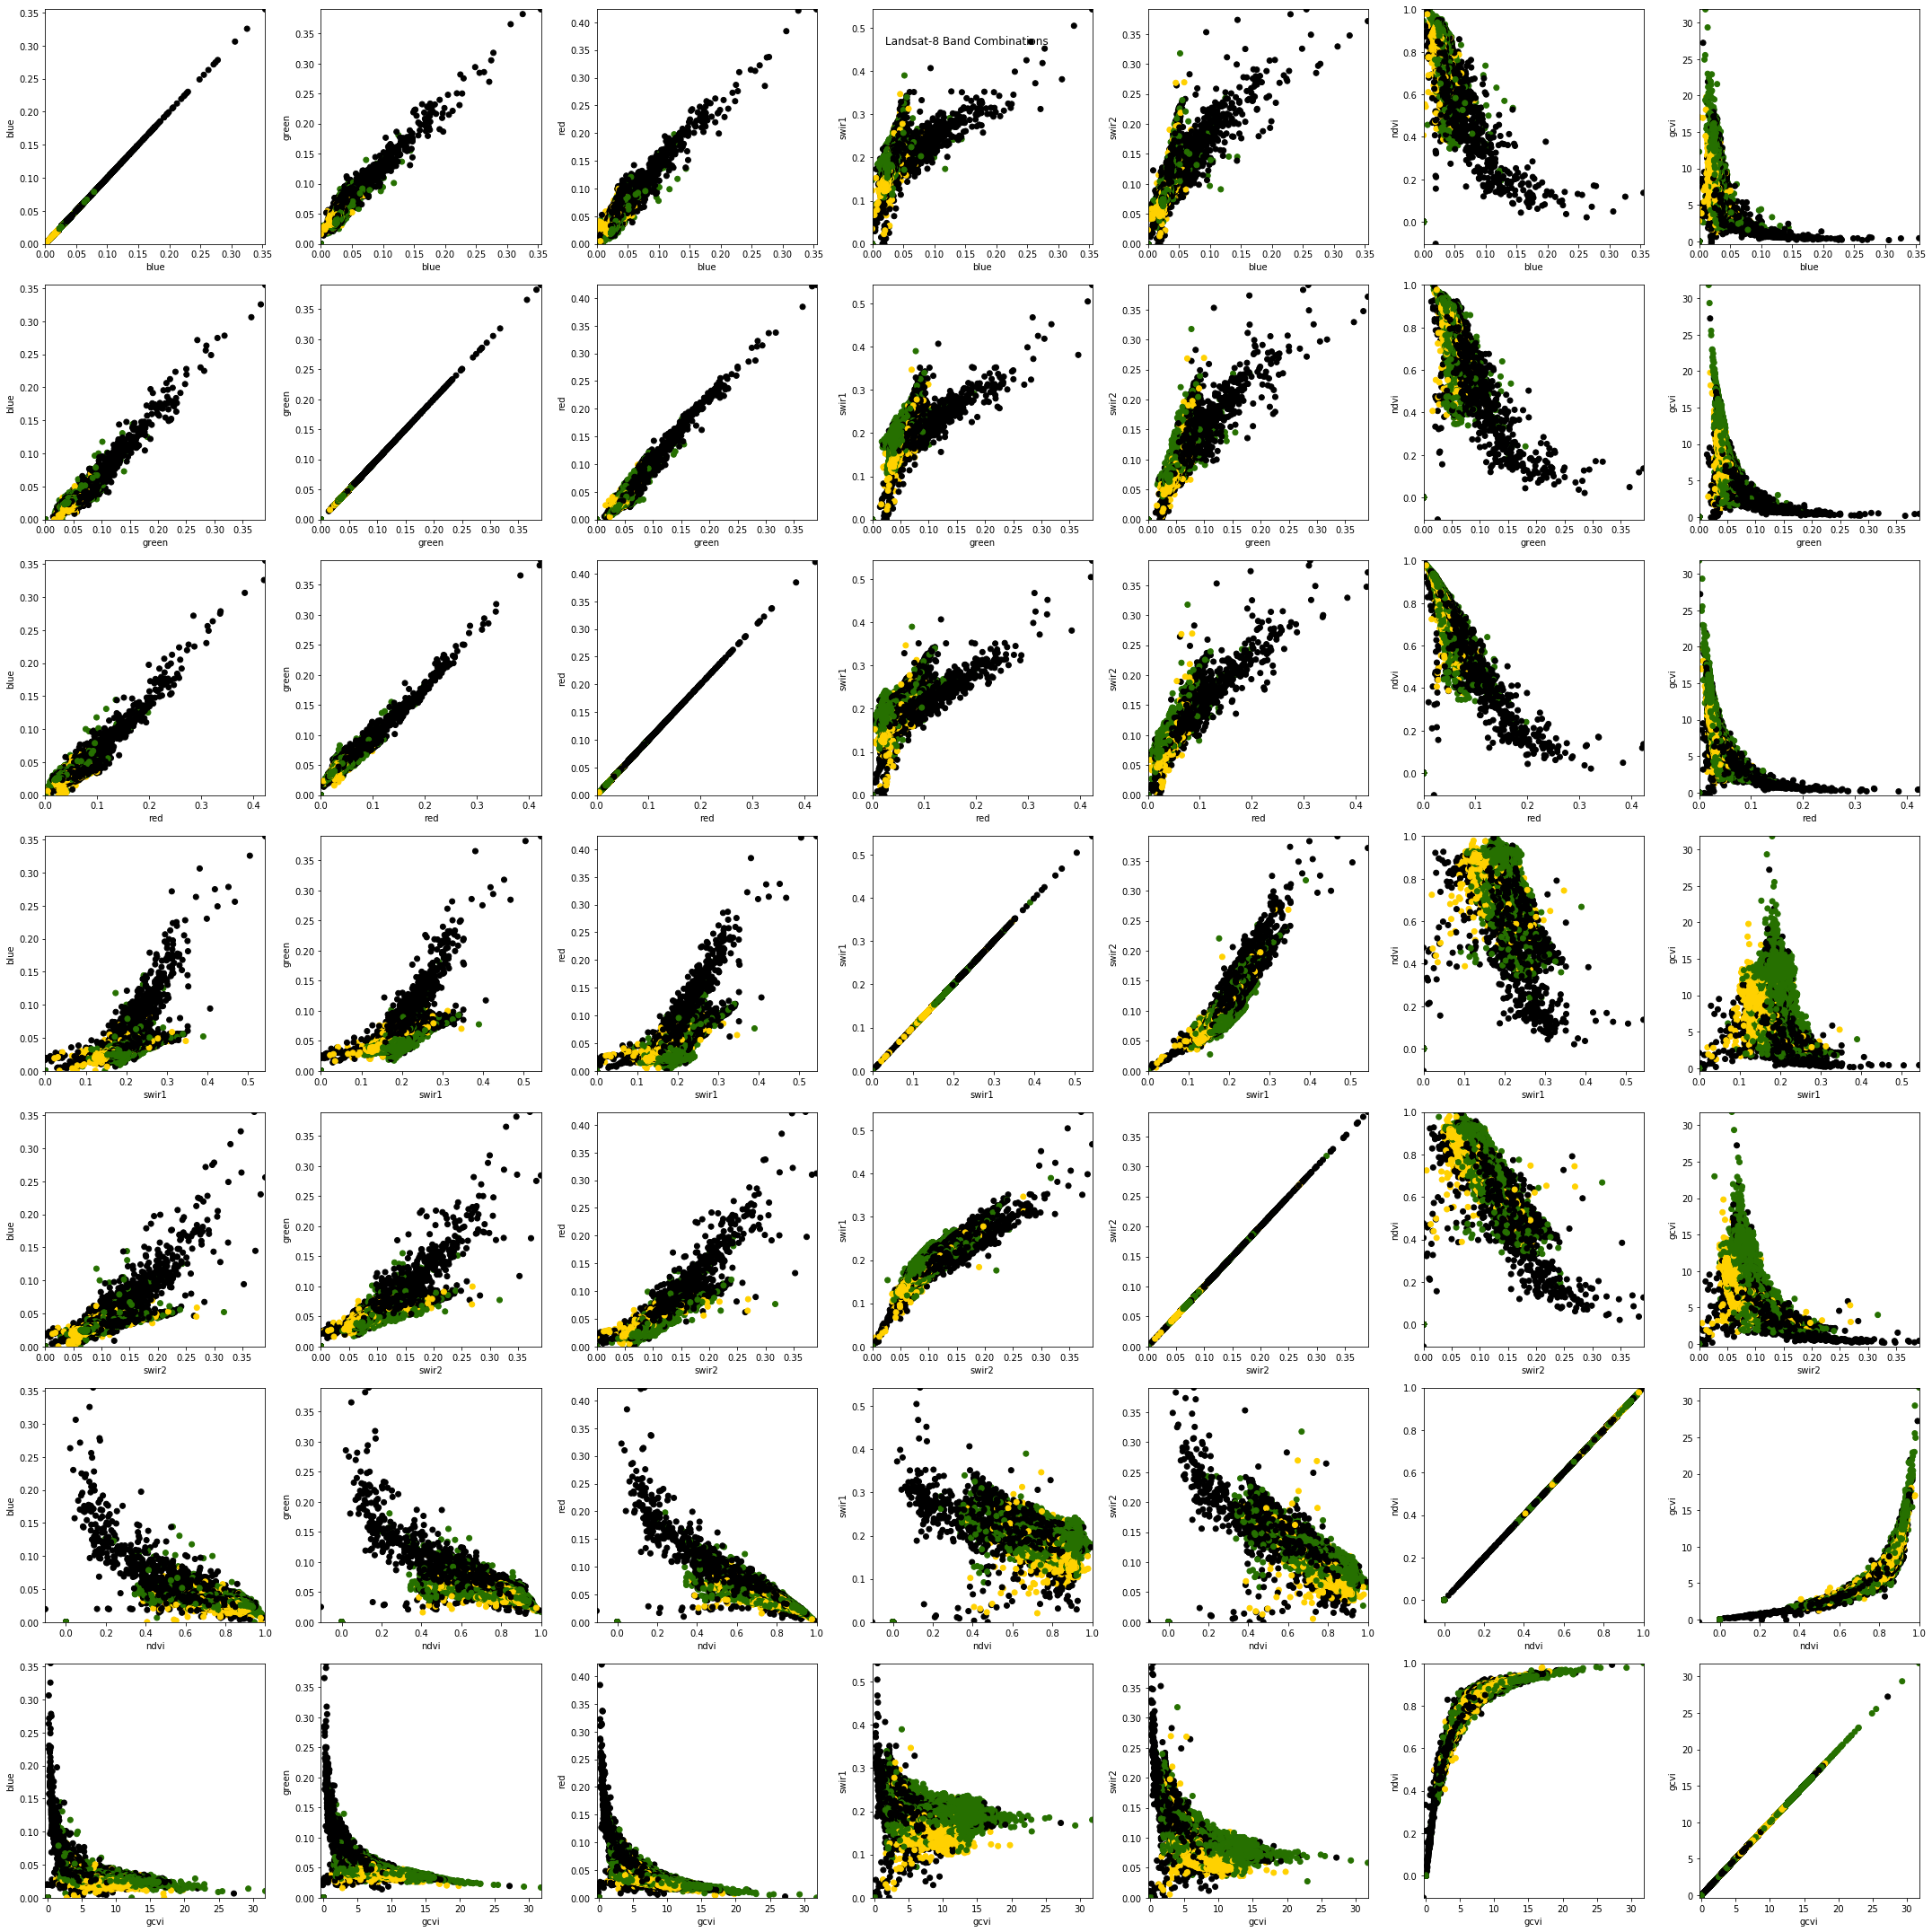

In [16]:

fig, ax = plt.subplots(nrows=7, ncols=7, figsize=[30,30])
for i in range(7):
    for j in range(7):
        ax[i,j].scatter(l30_img[:400, :400, i].flatten(), l30_img[:400, :400, j].flatten(), c=np.reshape(cdl_img[:400,:400,:3].flatten(), [400*400,3]))
        ax[i,j].set_xlabel(bands[i])
        ax[i,j].set_ylabel(bands[j])
        ax[i,j].set_xlim(l30_img[:400, :400, i].min(), l30_img[:400, :400, i].max())
        ax[i,j].set_ylim(l30_img[:400, :400, j].min(), l30_img[:400, :400, j].max())
fig.suptitle("Landsat-8 Band Combinations")
fig.tight_layout()


### Dimensionality reduction via PCA

Another way to evaluate the linear separability of the spectra is to use PCA to compute latent variables that have maximal variability across all spectra in the dataset.

In [18]:
# Apply PCA with 2 components to the data
# Only using 2 components right now to visualize in 2D
pca = PCA(n_components=2)
l30_pca = pca.fit_transform(np.reshape(l30_img[:400,:400], [400*400, 7]))

pca2 = PCA(n_components=2)
s30_pca = pca2.fit_transform(np.reshape(s30_img[:400,:400], [400*400, 7]))

Text(0,0.5,'PC 2')

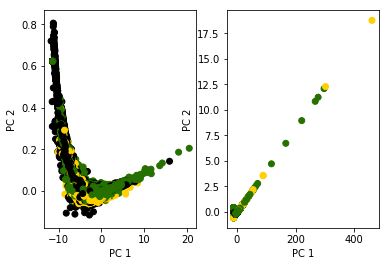

In [19]:
# Plot the data in the principal subspace colored by class
fig, axes = plt.subplots(ncols=2)
axes[0].scatter(l30_pca[:,0], l30_pca[:,1], c=np.reshape(cdl_img[:400,:400,:3].flatten(), [400*400,3]))
axes[1].scatter(s30_pca[:,0], s30_pca[:,1], c=np.reshape(cdl_img[:400,:400,:3].flatten(), [400*400,3]))

# Set axes labels
axes[0].set_xlabel("PC 1")
axes[0].set_ylabel("PC 2")
axes[1].set_xlabel("PC 1")
axes[1].set_ylabel("PC 2")

## 2b. Investigate separability with time-series

The above visualizations show that crop types in our study area are not linearly separable using only the reflectance spectra or vegetation indices for a single image. Next, we want to investigate if the crop classes are linearly separable using the time series of reflectances in each band, or the "time spectra".

### Load the HLS data
First, we'll load all the L30 and S30 observations we have for each band separately for just our example MGRS tile (16SCJ). 

In [20]:
# Path to the 2018 observations for 16SCJ
l30_path = '%s/16SCJ/L30/2018'

# Get the number of observations for that year
n_l30 = len(os.listdir(os.path.join(fp_illinois, l30_path % 'ndvi')))

# Get a list of the days of the year of each observation
l30_doys = []
for name in sorted(os.listdir(os.path.join(fp_illinois, l30_path % 'ndvi'))):
    l30_doys.append(int(name.split('.')[3][4:]))
    
print l30_doys

# Create a dictionary to hold time series cube for each band
l30_tseries_by_band = {}

# Iterate through each band directory
for b, band in enumerate(bands):
    if band in l30_tseries_by_band.keys():
        continue
    # Create an np.array to hold the t-band time-series (all tiles are 3660 x 3660)
    l30_tseries = np.ndarray([3660, 3660, n_l30])
    # Iterate through each observation
    for i, obs in enumerate(sorted(os.listdir(os.path.join(fp_illinois, l30_path % band)))):
        # Read/open the raster file
        obs_r = rasterio.open(os.path.join(fp_illinois, l30_path % band, obs))
        # Add this observation to the time series cube
        l30_tseries[:,:,i] = obs_r.read(1)
    l30_tseries_by_band[band] = l30_tseries
    
print l30_tseries_by_band.keys()

# # Load each band into the array
# for i, band in enumerate(['blue', 'green', 'red', 'swir1', 'swir2', 'ndvi', 'gcvi']):
#     s30_fp = os.path.join(fp_illinois, s30_path % (band, band))
#     s30_raster = rasterio.open(s30_fp)
#     s30_img[:,:,i] = s30_raster.read(1)

[5, 14, 21, 30, 37, 46, 53, 62, 69, 78, 85, 94, 101, 110, 117, 126, 133, 142, 149, 158, 165, 174, 181, 190, 197, 206, 213, 222, 229, 238, 245, 254, 261, 270, 277, 286, 293, 302, 309, 318, 325, 334, 341, 350, 357]
['blue', 'swir1', 'swir2', 'gcvi', 'green', 'ndvi', 'red']


In [21]:
print l30_tseries_by_band['ndvi'].shape

(3660, 3660, 45)


### Seasonal slope of NDVI vs. SWIR1

To plot the seasonal slope of NDVI vs. SWIR1 to see if these features make the crop types linearly separable, we first need to calculate the slope of the NDVI values for each pixel in the image over time.

To start, we'll plot the NDVI over time for a corn and soybean example.

5
1
176
[0.00024108 0.11189461]


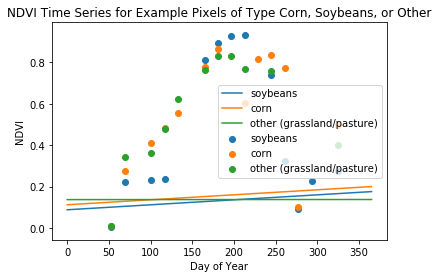

In [22]:
print cdl_labels[290,50]
print cdl_labels[25,100]
print cdl_labels[350,66]

nodata_inds = np.where(np.isnan(l30_tseries_by_band['ndvi']))
l30_tseries_by_band['ndvi'][nodata_inds] = 0

# Plot scatter - but I want these to be lines :(
plt.scatter(l30_doys, np.ma.masked_equal(l30_tseries_by_band['ndvi'][290,50], 0), label='soybeans')
plt.scatter(l30_doys, np.ma.masked_equal(l30_tseries_by_band['ndvi'][25,100], 0), label='corn')
plt.scatter(l30_doys, np.ma.masked_equal(l30_tseries_by_band['ndvi'][350,66], 0), label='other (grassland/pasture)')

# Plot linear regression lines
x = np.arange(0, 366)
fit_sbean = np.polyfit(l30_doys, np.ma.masked_equal(l30_tseries_by_band['ndvi'][290,50], 0), deg=1)
plt.plot(x, fit_sbean[0]*x + fit_sbean[1], label='soybeans')
fit_corn = np.polyfit(l30_doys, np.ma.masked_equal(l30_tseries_by_band['ndvi'][25,100], 0), deg=1)
plt.plot(x, fit_corn[0]*x + fit_corn[1], label='corn')
fit_other = np.polyfit(l30_doys, np.ma.masked_equal(l30_tseries_by_band['ndvi'][350,66], 0), deg=1)
plt.plot(x, fit_other[0]*x + fit_other[1], label='other (grassland/pasture)')
plt.xlabel("Day of Year")
plt.ylabel("NDVI")
plt.title("NDVI Time Series for Example Pixels of Type Corn, Soybeans, or Other")
plt.legend()

print fit_corn

# The below code would be used to plot the NDVI time series for each class with error bars
# but it's too slow :( 
# # Make a pandas dataframe to store the doy and NDVI for each pixel
# df_l30_ndvi = pd.DataFrame()
# df_l30_ndvi['doy'] = None
# df_l30_ndvi['ndvi'] = None
# df_l30_ndvi['crop_type'] = None

# l30_ndvi = l30_tseries_by_band['ndvi'][:400,:400]
# idx = 0
# for row in range(l30_ndvi.shape[0]):
#     for col in range(l30_ndvi.shape[1]):
#         for day in range(l30_ndvi.shape[2]):
#             df_l30_ndvi[idx, 'doy'] = l30_doys[day]
#             df_l30_ndvi[idx, 'ndvi'] = l30_ndvi[row, col, day]
#             cdl_class = cdl_labels[row, col]
#             if cdl_class == 1:
#                 crop_type = 'corn'
#             elif cdl_class == 5:
#                 crop_type = 'soybean'
#             else:
#                 crop_type = 'other'
#             df_l30_ndvi[idx, 'crop_type'] = crop_type
#             idx += 1
#             if idx % 100000 == 0:
#                 print("%f \% complete" % (float(idx)/l30_ndvi.shape[0]*l30_ndvi.shape[1]*l30_ndvi.shape[2])*100)
            

Seems like it could be promising, at least to separate out the 'other' class. But these are only a few examples out of millions, so we need to compute the slope for all of the pixels in our sample area.

In [23]:
# Mask out all the NaN pixels
l30_tseries_by_band['ndvi'] = np.ma.masked_where(np.isnan(l30_tseries_by_band['ndvi']), l30_tseries_by_band['ndvi'])

In [24]:
# Make an nparray to hold the slopes
ndvi_slope = np.ndarray([l30_tseries_by_band['ndvi'].shape[0], l30_tseries_by_band['ndvi'].shape[1]])
# Go through each pixel and calculate the slope of the linear regression line 
for row in range(l30_tseries_by_band['ndvi'].shape[0]):
    fit = np.polynomial.polynomial.polyfit(x=l30_doys, y=l30_tseries_by_band['ndvi'][row].T, deg=1)
    ndvi_slope[row] = fit[1] # returned in reverse order from np.polyfit


Now that we've computed the slope of the NDVI time-series for all the pixels, we can plot seasonal NDVI slope vs. SWIR1 and see if that improves the linear separability of the crop types.

Text(0.5,1,'NDVI Slope vs. SWIR1 for Landsat-8, 8/1/2018')

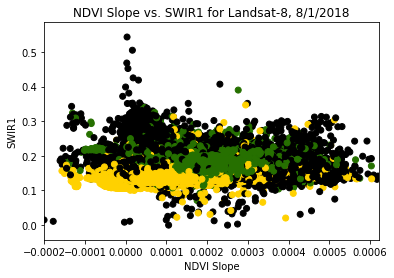

In [29]:
doy = np.where(np.array(l30_doys)==213)
plt.scatter(ndvi_slope[:400,:400], l30_tseries_by_band['swir1'][:400,:400,doy_213], c=np.reshape(cdl_img[:400,:400,:3].flatten(), [400*400,3]))
plt.xlim(ndvi_slope[:400,:400].min(), ndvi_slope[:400,:400].max())
plt.xlabel("NDVI Slope")
plt.ylabel("SWIR1")
plt.title("NDVI Slope vs. SWIR1 for Landsat-8, 8/1/2018")

In [ ]:
# Next: Play around with day of year and using SWIR at max NDVI over the time series?

## Filter images 
We want to only include the image tiles that intersect with Illinois in our analysis. We also want to calculate various properties about each observation, e.g., what fraction of the total images do not have any data (as a result of quality masking).

In [9]:
# Create a pandas DataFrame to store the info in
df = pd.DataFrame()
df['tile'] = None
df['year'] = None
df['doy'] = None
df['frac_nodata'] = None
df['max_ndvi'] = None
# Note: may want to add/replace things here in the future, e.g.:
# median instead of max NDVI, GCVI, etc.

In [ ]:
# Iterate through the available tiles
idx = 0
illinois_tiles = glob(os.path.join(fp_illinois, 'ndvi', '15*')) + glob(os.path.join(fp_illinois, 'ndvi', '16*'))
for i, tile in enumerate(illinois_tiles):
    t0 = time.time()
    for year in os.listdir(os.path.join(fp_illinois, 'ndvi', tile, 'L30')):
        for obs in os.listdir(os.path.join(fp_illinois, 'ndvi', tile, 'L30', year)):
            # Store relevant metadata
            df.loc[idx, 'tile'] = tile
            df.loc[idx, 'year'] = int(year)
            df.loc[idx, 'doy'] = int(obs.split('.')[3][4:])
            # Read the tile
            obs_r = rasterio.open(os.path.join(fp_illinois, 'ndvi', tile, 'L30', year, obs))
            obs_im = obs_r.read(1)
            # Calculate fraction of no-data (NaN) pixels
            nodata = np.where(np.isnan(obs_im))
            df['frac_nodata'] = (float(len(nodata[0]))/(3660*3660))
            # Set all no-data pixels to -1, otherwise NaNs will mess up max() computation
            obs_im[nodata] = -1
            # Get the max value over all NDVI pixels in this tile
            max_ndvi = obs_im.max()
            df.loc[idx, 'max_ndvi'] = max_ndvi
            # Increment row index
            idx += 1
    # Tell the user how far we are
    if i % 5 == 0:
        print("Processed %d out of %d tiles (%f s)" % (i+1, len(illinois_tiles), time.time()-t0))
    
# Save the df so we don't have to keep doing this and can use pd.read_pickle() later
df.to_pickle('l30_illinois_metadata.pkl')


Processed 1 out of 34 tiles (71.231786 s)


/home/kernerh/.conda/envs/uscorn/lib/python2.7/site-packages/rasterio/__init__.py:216: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Processed 6 out of 34 tiles (68.039942 s)


In [ ]:
# TODO: Filter out images with > x% no data?

## Annual variability
A variety of factors have created an irregular growing season in the midwest in 2019 compared to previous years. Due to new tariffs on soybeans exported to China that made planting soybeans unprofitable, many farmers planted corn where they would typically have planted soybeans. Extreme flooding in the midwest in the spring/summer of 2019 also caused farmers to wait as long as possible before planting crops. Consequently, we expect that compared to previous years, in 2019 we will observe 1) increased area in which corn was planted than soybeans, and 2) a later shift in the days of the year in which crops are developing.

### Delayed growing season
To visualize the potential shift in the growing season to later days of the year in 2019, we plotted the day of year (DOY) vs. max NDVI for all Landsat scenes in our dataset between 2016-2019.

In [15]:
# Calculate the size of the dataset
print("Total # of observation: %d" % len(df.index))
grouped = df.groupby('year')
for year, values in grouped:
    print("Total # of observations in %d: %d" % (year, len(values.index)))

Total # of observation: 13216
Total # of observations in 2013: 618
Total # of observations in 2014: 91
Total # of observations in 2015: 86
Total # of observations in 2016: 1426
Total # of observations in 2017: 3731
Total # of observations in 2018: 4465
Total # of observations in 2019: 2799


In [35]:
df = pd.read_pickle('l30_metadata.pkl')
df.groupby('year').plot(x='doy', y='max_ndvi')

tile  year  doy max_ndvi
0  35UMS  2018   45       -1
1  35UMS  2018  342       -1
2  35UMS  2018  292   0.9959
3  35UMS  2018  189        1
4  35UMS  2018   86        1

Empty GeoDataFrame
Columns: [Name, Description, geometry]
Index: []